In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import shap
from lime.lime_tabular import LimeTabularExplainer

# CTGAN (SDV)
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


/Users/feldaega/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = "creditcard.csv"   # <- ganti

df = pd.read_csv(DATA_PATH)
target_col = "Class"
assert target_col in df.columns, "Kolom label 'Class' tidak ditemukan."

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train class counts:\n", y_train.value_counts())
print("Test class counts:\n", y_test.value_counts())


Train: (227845, 30)  Test: (56962, 30)
Train class counts:
 Class
0    227451
1       394
Name: count, dtype: int64
Test class counts:
 Class
0    56864
1       98
Name: count, dtype: int64


In [3]:
def eval_metrics(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "AUPRC": average_precision_score(y_true, y_proba),
        "CM": confusion_matrix(y_true, y_pred)
    }

def show_cm(cm, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure()
    disp.plot(values_format="d")
    plt.title(title)
    plt.show()

def plot_pr(y_true, y_proba, label):
    p, r, _ = precision_recall_curve(y_true, y_proba)
    plt.plot(r, p, label=label)


In [4]:
def make_rf_fast():
    return RandomForestClassifier(
        n_estimators=120,     # lebih kecil
        max_depth=18,         # dibatasi
        min_samples_split=4,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

def make_xgb_fast():
    return XGBClassifier(
        n_estimators=220,     # lebih kecil
        max_depth=4,
        learning_rate=0.07,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        n_jobs=-1,
        tree_method="hist"    # mempercepat di Colab
    )


Training: RF_Baseline


<Figure size 640x480 with 0 Axes>

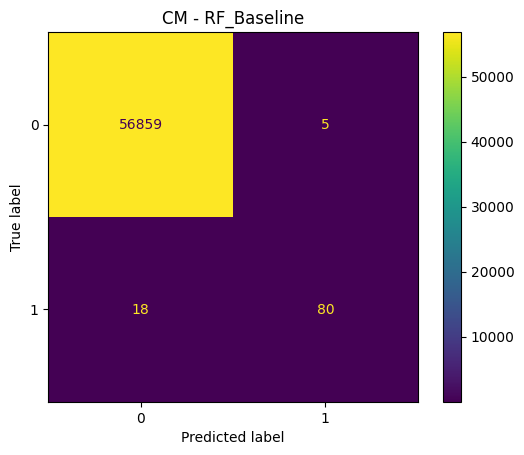

Training: XGB_Baseline


<Figure size 640x480 with 0 Axes>

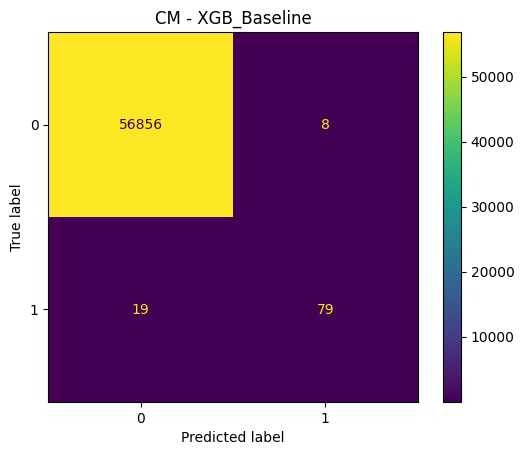

In [5]:
baseline_models = {
    "RF_Baseline": Pipeline([("scaler", RobustScaler()), ("clf", make_rf_fast())]),
    "XGB_Baseline": Pipeline([("scaler", RobustScaler()), ("clf", make_xgb_fast())]),
}

results = {}
trained = {}

for name, model in baseline_models.items():
    print("Training:", name)
    model.fit(X_train, y_train)
    trained[name] = model

    y_proba = model.predict_proba(X_test)[:, 1]
    out = eval_metrics(y_test.values, y_proba)

    results[name] = {"Scenario": "Baseline", "Model": name.split("_")[0], "F1": out["F1"], "AUPRC": out["AUPRC"]}
    show_cm(out["CM"], f"CM - {name}")


Training: RF_SMOTE


/Users/feldaega/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

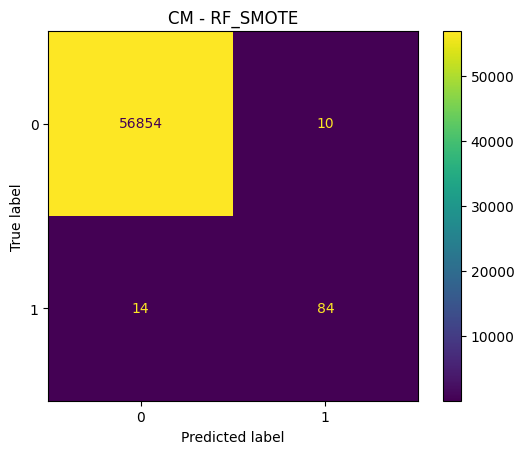

Training: XGB_SMOTE


/Users/feldaega/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

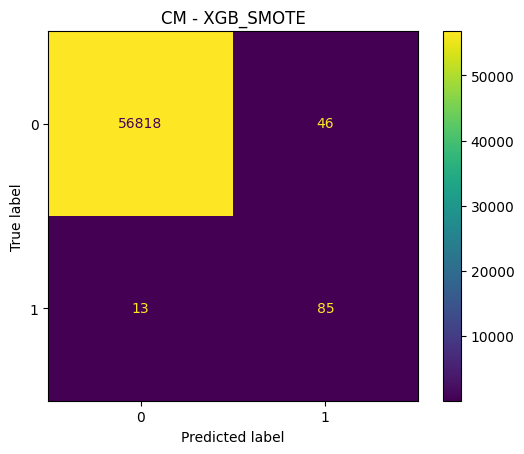

In [6]:
# Fraud dibuat 10% dari normal -> jauh lebih cepat daripada 1:1
smote_fast = SMOTE(
    random_state=RANDOM_STATE,
    k_neighbors=3,
    sampling_strategy=0.1  # <- kunci percepatan
)

smote_models = {
    "RF_SMOTE": ImbPipeline([("scaler", RobustScaler()), ("smote", smote_fast), ("clf", make_rf_fast())]),
    "XGB_SMOTE": ImbPipeline([("scaler", RobustScaler()), ("smote", smote_fast), ("clf", make_xgb_fast())]),
}

for name, model in smote_models.items():
    print("Training:", name)
    model.fit(X_train, y_train)     # SMOTE terjadi hanya pada TRAIN (aman dari leakage)
    trained[name] = model

    y_proba = model.predict_proba(X_test)[:, 1]
    out = eval_metrics(y_test.values, y_proba)

    results[name] = {"Scenario": "SMOTE(0.1)", "Model": name.split("_")[0], "F1": out["F1"], "AUPRC": out["AUPRC"]}
    show_cm(out["CM"], f"CM - {name}")


/Users/feldaega/Library/Python/3.9/lib/python/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/Users/feldaega/Library/Python/3.9/lib/python/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Fitting CTGAN on fraud-only (subset)...
Sampling synthetic fraud: 197
CTGAN augmented class counts:
 Class
0    227451
1       591
Name: count, dtype: int64
Training: RF_CTGAN


<Figure size 640x480 with 0 Axes>

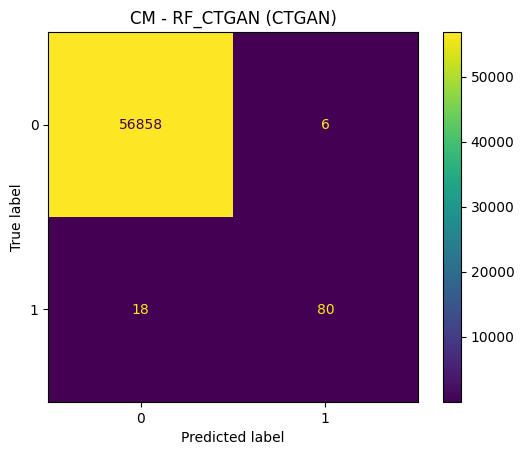

Training: XGB_CTGAN


<Figure size 640x480 with 0 Axes>

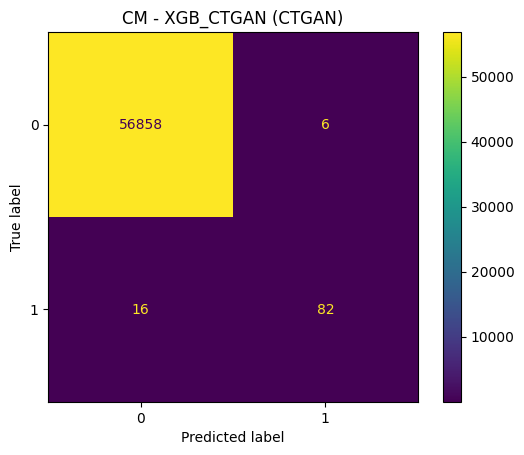

In [15]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

# ====== CTGAN (FAST & STABLE) ======
train_df = X_train.copy()
train_df[target_col] = y_train.values

fraud_train = train_df[train_df[target_col] == 1].copy()
normal_train = train_df[train_df[target_col] == 0].copy()

# subset fraud untuk fit CTGAN (biar cepat)
fraud_fit = fraud_train.sample(min(len(fraud_train), 300), random_state=RANDOM_STATE)

# metadata untuk CTGAN (sesuai data yang dipakai fit)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=fraud_fit)

ctgan = CTGANSynthesizer(
    metadata,
    epochs=10,          # bisa 10–20
    batch_size=64,      # stabil di laptop
    pac=1,              # penting biar tidak error assert pac
    enforce_min_max_values=True,
    enforce_rounding=False,
    verbose=False
)

print("Fitting CTGAN on fraud-only (subset)...")
ctgan.fit(fraud_fit)

# jumlah sintetis (biar tidak bengkak)
n_synth = max(100, len(fraud_train)//2)
print("Sampling synthetic fraud:", n_synth)
fraud_synth = ctgan.sample(n_synth)
fraud_synth[target_col] = 1

# gabungkan menjadi train augmented
aug_train_df = pd.concat([normal_train, fraud_train, fraud_synth], ignore_index=True)
X_train_ctgan = aug_train_df.drop(columns=[target_col])
y_train_ctgan = aug_train_df[target_col].astype(int)

print("CTGAN augmented class counts:\n", y_train_ctgan.value_counts())

# ====== train model dengan data CTGAN augmented ======
ctgan_models = {
    "RF_CTGAN": Pipeline([("scaler", RobustScaler()), ("clf", make_rf_fast())]),
    "XGB_CTGAN": Pipeline([("scaler", RobustScaler()), ("clf", make_xgb_fast())]),
}

for name, model in ctgan_models.items():
    print("Training:", name)
    model.fit(X_train_ctgan, y_train_ctgan)
    trained[name] = model

    y_proba = model.predict_proba(X_test)[:, 1]
    out = eval_metrics(y_test.values, y_proba)

    results[name] = {"Scenario": "CTGAN", "Model": name.split("_")[0], "F1": out["F1"], "AUPRC": out["AUPRC"]}
    show_cm(out["CM"], f"CM - {name} (CTGAN)")


In [16]:
results_table = pd.DataFrame(results).T

# pastikan kolom numerik jadi float
results_table["F1"] = results_table["F1"].astype(float)
results_table["AUPRC"] = results_table["AUPRC"].astype(float)

results_table = results_table.sort_values("AUPRC", ascending=False)
results_table


,Scenario,Model,F1,AUPRC
RF_SMOTE,SMOTE(0.1),RF,0.875000,0.884318
XGB_CTGAN,CTGAN,XGB,0.881720,0.878968
RF_CTGAN,CTGAN,RF,0.869565,0.876832
XGB_Baseline,Baseline,XGB,0.854054,0.874008
RF_Baseline,Baseline,RF,0.874317,0.864817
XGB_SMOTE,SMOTE(0.1),XGB,0.742358,0.855423


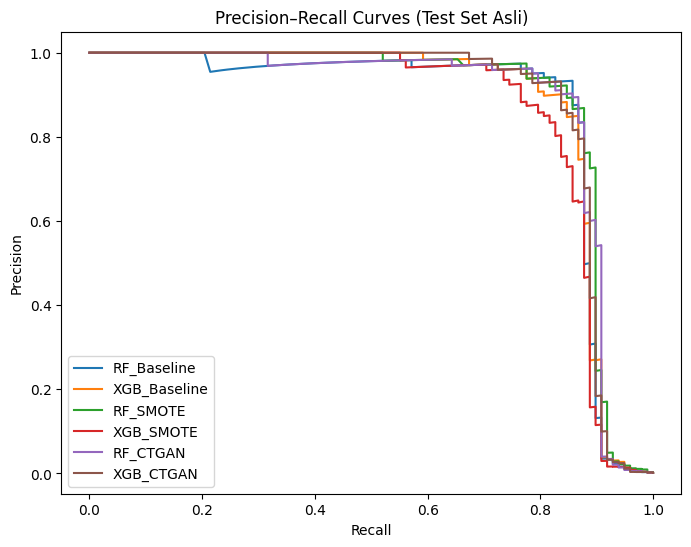

In [17]:
plt.figure(figsize=(8,6))

for name, model in trained.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    plot_pr(y_test.values, y_proba, label=name)

plt.title("Precision–Recall Curves (Test Set Asli)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


In [18]:
def show_delta(base_name, ctgan_name):
    if base_name not in results_table.index or ctgan_name not in results_table.index:
        print(f"Skip: {base_name} atau {ctgan_name} tidak ada di results_table.")
        return

    base_f1 = float(results_table.loc[base_name, "F1"])
    base_auprc = float(results_table.loc[base_name, "AUPRC"])
    ct_f1 = float(results_table.loc[ctgan_name, "F1"])
    ct_auprc = float(results_table.loc[ctgan_name, "AUPRC"])

    print(f"\n{ctgan_name} vs {base_name}")
    print(f"  F1    : {base_f1:.4f} -> {ct_f1:.4f} (Δ {ct_f1-base_f1:+.4f})")
    print(f"  AUPRC : {base_auprc:.4f} -> {ct_auprc:.4f} (Δ {ct_auprc-base_auprc:+.4f})")
    if (ct_auprc - base_auprc) > 0:
        print("  Kesimpulan: CTGAN efektif (AUPRC meningkat).")
    else:
        print("  Kesimpulan: CTGAN belum efektif (AUPRC tidak meningkat).")

show_delta("RF_Baseline", "RF_CTGAN")
show_delta("XGB_Baseline", "XGB_CTGAN")



RF_CTGAN vs RF_Baseline
  F1    : 0.8743 -> 0.8696 (Δ -0.0048)
  AUPRC : 0.8648 -> 0.8768 (Δ +0.0120)
  Kesimpulan: CTGAN efektif (AUPRC meningkat).

XGB_CTGAN vs XGB_Baseline
  F1    : 0.8541 -> 0.8817 (Δ +0.0277)
  AUPRC : 0.8740 -> 0.8790 (Δ +0.0050)
  Kesimpulan: CTGAN efektif (AUPRC meningkat).


In [19]:
print("\n=== Ranking berdasarkan AUPRC (tertinggi = terbaik) ===")
display(results_table.sort_values("AUPRC", ascending=False))



=== Ranking berdasarkan AUPRC (tertinggi = terbaik) ===


,Scenario,Model,F1,AUPRC
RF_SMOTE,SMOTE(0.1),RF,0.875000,0.884318
XGB_CTGAN,CTGAN,XGB,0.881720,0.878968
RF_CTGAN,CTGAN,RF,0.869565,0.876832
XGB_Baseline,Baseline,XGB,0.854054,0.874008
RF_Baseline,Baseline,RF,0.874317,0.864817
XGB_SMOTE,SMOTE(0.1),XGB,0.742358,0.855423
